<a href="https://colab.research.google.com/github/Schimmenti/Creep/blob/master/Creep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from numba import njit,jit
import math
from sklearn.metrics.pairwise import manhattan_distances
import networkx as nx

In [2]:
def center(z):
    # "-1" profiles
    # sum of columns
    mask1 = (z==-1).sum(axis=0)
    # sum of rows
    mask2 = (z==-1).sum(axis=1)
    # column at which we find the actual interface
    max1 = mask1.max()
    boundary1 = np.argwhere(mask1 == max1).flatten()
    lb1 = np.argmax(np.diff(boundary1))
    # row at which we find the actual interface
    max2 = mask2.max()
    boundary2 = np.argwhere(mask2==max2).flatten()
    lb2 = np.argmax(np.diff(boundary2))
    # actual boundary
    minb_1, maxb_1 = boundary1[lb1],boundary1[lb1+1]
    minb_2, maxb_2 = boundary2[lb2],boundary2[lb2+1]
    # center
    xc = (minb_1+maxb_1)/2
    yc = (minb_2+maxb_2)/2
    # radii
    radius_x = (maxb_1-minb_1)/2
    radius_y = (maxb_2-minb_2)/2
    return xc,yc,radius_x,radius_y

In [3]:
base_link = 'https://raw.githubusercontent.com/Schimmenti/Creep/master/file_field%1.2f.csv'

In [4]:
field = 0.13
data = pd.read_csv(base_link % field, header=None).values

In [5]:
xc, yc, r_x, r_y = center(data)

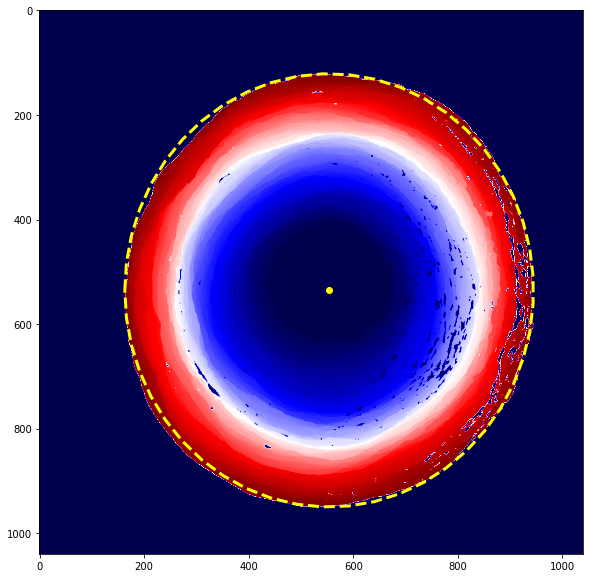

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(data, cmap='seismic')
plt.scatter(xc, yc, c='yellow')
thetas_plot = np.linspace(-np.pi, np.pi )
plt.plot(xc+r_x*np.cos(thetas_plot), yc+r_y*np.sin(thetas_plot), c='yellow', lw=3, ls='dashed')
plt.show()

In [7]:
timesteps, amounts = np.unique(data,return_counts=True)
timesteps = timesteps[1:]
amounts = amounts[1:]
T = timesteps.max() + 1

In [8]:
topplings = np.zeros(T)
topplings[timesteps] = amounts
area = np.cumsum(topplings)

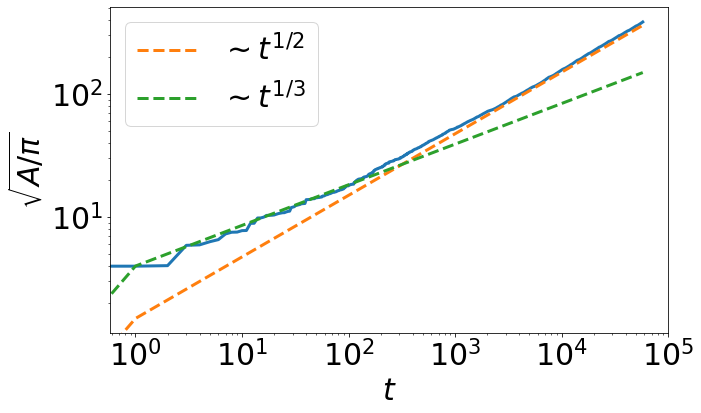

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(np.sqrt(area/np.pi), lw=3)
plt.plot(np.arange(0,T), 1.5*np.arange(0,T)**0.5, label='$\sim t^{1/2}$', ls='dashed', lw=3)
plt.plot(np.arange(0,T), 4*np.arange(0,T)**0.33, label='$\sim t^{1/3}$', ls='dashed', lw=3)
plt.ylabel("$\sqrt{A/\pi}$", fontsize=30)
plt.xlabel("$t$", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=30)
plt.show()

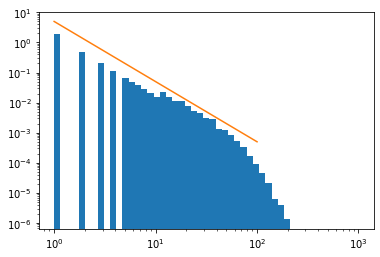

In [40]:
plt.hist(topplings, bins=np.logspace(0,3),density=True)
plt.plot(np.logspace(0,2),5*np.logspace(0,2)**(-2.0))
plt.xscale('log')
plt.yscale('log')
plt.show()

In [115]:
polar = {}
for t in timesteps:
  if(t % 5000 == 0):
    print(t)
  indices = np.argwhere(data==t)
  delta_r = indices[:, 0]-yc
  delta_c = indices[:, 1]-xc
  r_t =np.sqrt(delta_r**2+delta_c**2)
  theta_t = np.arctan2(delta_r, delta_c)
  polar[t] = (r_t, theta_t)

0
10000
15000
20000
25000
30000
40000
45000
55000


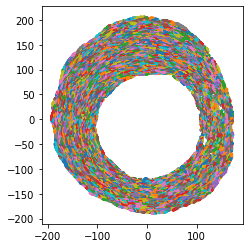

In [120]:
for t in polar.keys():
  if(t > 10000):
    break
  plt.plot(polar[t][0]*np.cos(polar[t][1]),polar[t][0]*np.sin(polar[t][1]))
plt.gca().set_aspect('equal')

In [11]:
events = {}
manhattan_tolerance = 2
for t in timesteps:
  if(t % 5000 == 0):
    print(t)
  t_events = []
  indices = np.argwhere(data==t)
  adj_matr = np.minimum(manhattan_distances(indices[:,0][:,None], indices[:,0][:,None]),manhattan_distances(indices[:,1][:,None], indices[:,1][:,None])) <= manhattan_tolerance
  g = nx.from_numpy_array(adj_matr)
  components = list(nx.connected_components(g))
  for comp in components:
    t_events.append(indices[list(comp),:])
  events[t] = t_events

0
10000
15000
20000
25000
30000
40000
45000
55000


In [12]:
catalog = []
for t, evs in events.items():
  for ev in evs:
    catalog.append((t, len(ev), ev[:,0].mean(), ev[:,1].mean()))
catalog = np.array(catalog)

In [85]:
b = 1.0
max_dt_backward = 5000
g_decl = nx.DiGraph()
for event_idx in range(catalog.shape[0]):
  if(event_idx % 1000 == 0):
    print("%.2f" % (100*event_idx/catalog.shape[0]))
  best_n_ij = np.infty
  best_i = -1
  for event_jdx in range(max(0,event_idx-max_dt_backward),event_idx):
    dt_ij = catalog[event_idx, 0] - catalog[event_jdx, 0]
    # can't connect equal-time events
    if(dt_ij == 0):
      continue
    dr_ij = np.sqrt((catalog[event_idx, 1] - catalog[event_jdx, 1])**2+(catalog[event_idx, 2] - catalog[event_jdx, 2])**2)
    size_effect_j = np.exp(-2*np.log(catalog[event_jdx,3]))
    n_ij = dt_ij*(dr_ij**2)*size_effect_j
    if(n_ij < best_n_ij):
      best_i = event_idx
      best_n_ij = n_ij
  g_decl.add_edge(event_idx,event_jdx, weight=best_n_ij)

0.00
1.87
3.74
5.61
7.48
9.35
11.22
13.09
14.96
16.83
18.71
20.58
22.45
24.32
26.19
28.06
29.93
31.80
33.67
35.54
37.41
39.28
41.15
43.02
44.89
46.76
48.63
50.50
52.37
54.25
56.12
57.99
59.86
61.73
63.60
65.47
67.34
69.21
71.08
72.95
74.82
76.69
78.56
80.43
82.30
84.17
86.04
87.91
89.79
91.66
93.53
95.40
97.27
99.14


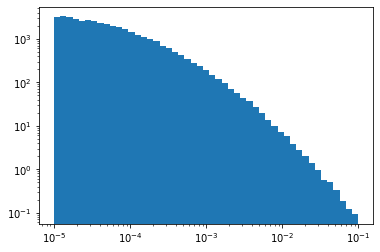

In [89]:
weights = np.array([w for n1,n2, w in g_decl.edges(data='weight')])
weights[0] = 0
plt.hist(np.sort(weights[weights>0]), bins=np.logspace(-5,-1), density=True)
plt.xscale('log')
plt.yscale('log')


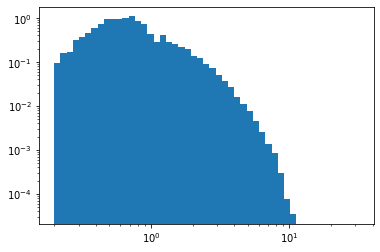

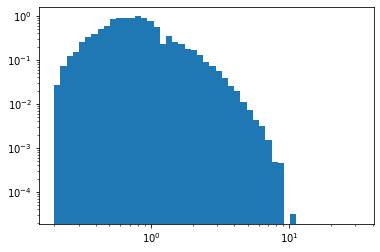

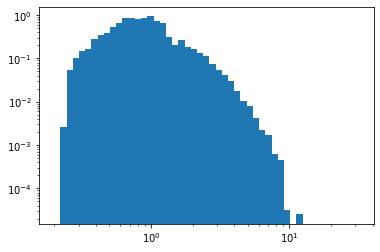

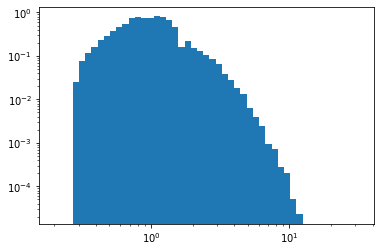

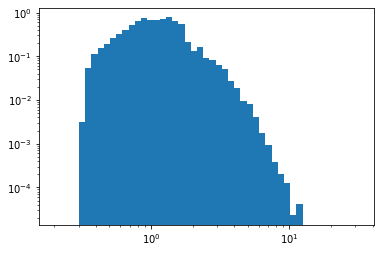

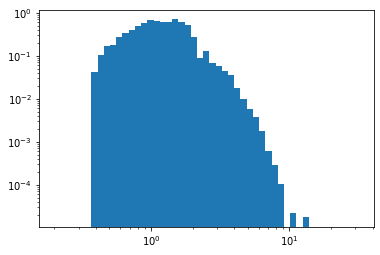

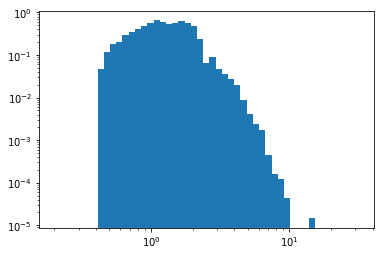

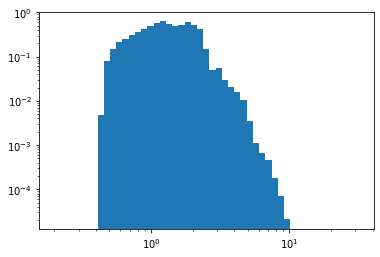

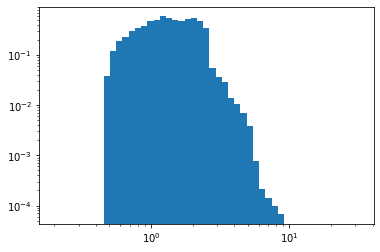

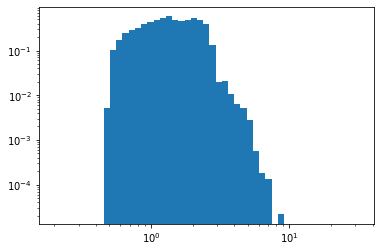

In [94]:
for n_max in np.logspace(-4,-2,10):
  g_cut = g_decl.copy()
  g_cut.remove_edges_from([(n1, n2) for n1, n2, w in g_cut.edges(data="weight") if w <= n_max])
  n_c = np.array([len(c) for c in nx.weakly_connected_components(g_cut)])
  s_c = np.array([ catalog[list(c),3].sum()  for c in nx.weakly_connected_components(g_cut)])
  s_max = np.mean(s_c**2)/(2*np.mean(s_c))
  plt.hist(s_c/s_max, bins=np.logspace(-0.7,1.5), density=True)
  plt.yscale('log')
  plt.xscale('log')
  plt.show()